In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import datetime
import ccxt
import pybithumb
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc

from tpot import TPOTClassifier, TPOTRegressor
from sklearn.model_selection import train_test_split

/root/anaconda3/envs/torch/lib/python3.8/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [2]:
# binance
binance = ccxt.binance()
ohlcv = binance.fetch_ohlcv("BTC/USDT", "6h")

sample = pd.DataFrame(ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
sample['datetime'] = pd.to_datetime(sample['datetime'], unit='ms')
sample.set_index('datetime', inplace=True)

In [3]:
tweets = pd.read_csv("tweets_count.csv", encoding="utf-8")
tweets["datetime"] = tweets["date_date"]
tweets.set_index('datetime', inplace=True)
tweets = tweets[["600", "1200", "1800", "2400"]]
tweets.tail()



,600,1200,1800,2400
datetime,,,,
2021-05-25,0,347,1353,1103
2021-05-26,1045,1359,1372,1122
2021-05-27,998,967,1418,1000
2021-05-28,1061,1324,1470,1334
2021-05-29,882,1203,1388,1036


In [4]:
whales = pd.read_csv("Total.csv", encoding="utf-8")
whales.set_index('Time', inplace=True)
whales.dropna(inplace=True)
whales.tail()

,Amount(BTC)
Time,
2021-05-29,44145.820890
2021-05-30,26712.274260
2021-05-31,21702.009330
2021-06-01,9609.717670
2021-06-02,-1897.161125


In [5]:
for idx in whales.index:
    dates = idx.split("-")
    dates = [int(x) for x in dates]
    pd_0to6 = pd.Timestamp(dates[0], dates[1], dates[2], 0, 0, 0)
    pd_6to12 = pd.Timestamp(dates[0], dates[1], dates[2], 6, 0, 0)
    pd_12to18 = pd.Timestamp(dates[0], dates[1], dates[2], 12, 0, 0)
    pd_18to24 = pd.Timestamp(dates[0], dates[1], dates[2], 18, 0, 0)

    try:
        sample.loc[pd_0to6, 'whales'] = whales.loc[idx, 'Amount(BTC)']
        sample.loc[pd_6to12, 'whales'] = whales.loc[idx, 'Amount(BTC)']
        sample.loc[pd_12to18, 'whales'] = whales.loc[idx, 'Amount(BTC)']
        sample.loc[pd_18to24, 'whales'] = whales.loc[idx, 'Amount(BTC)']
    except:
        continue

sample.dropna(inplace=True)
sample

,open,high,low,close,volume,whales
datetime,,,,,,
2021-01-30 06:00:00,33503.72,34424.70,33137.80,33660.40,23458.419468,16112.790230
2021-01-30 12:00:00,33660.40,34500.00,33410.63,34253.67,20903.274146,16112.790230
2021-01-30 18:00:00,34252.02,34800.00,33966.40,34262.88,13591.829652,16112.790230
2021-01-31 00:00:00,34262.89,34342.69,33655.00,33756.39,12861.816557,12415.198970
2021-01-31 06:00:00,33757.17,33857.88,33205.00,33563.23,13671.823713,12415.198970
...,...,...,...,...,...,...
2021-06-01 18:00:00,36154.64,36800.00,35726.36,36693.09,13444.176826,9609.717670
2021-06-02 00:00:00,36694.85,36921.00,35920.00,36808.49,12422.303372,-1897.161125
2021-06-02 06:00:00,36808.49,37538.07,36661.53,37203.08,20882.754301,-1897.161125


In [6]:
sample['tweets'] = 0
for idx in tweets.index:
    dates = idx.split("-")
    dates = [int(x) for x in dates]
    pd_0to6 = pd.Timestamp(dates[0], dates[1], dates[2], 0, 0, 0)
    pd_6to12 = pd.Timestamp(dates[0], dates[1], dates[2], 6, 0, 0)
    pd_12to18 = pd.Timestamp(dates[0], dates[1], dates[2], 12, 0, 0)
    pd_18to24 = pd.Timestamp(dates[0], dates[1], dates[2], 18, 0, 0)

    sample.loc[pd_0to6, 'tweets'] = tweets.loc[idx, '600']
    sample.loc[pd_6to12, 'tweets'] = tweets.loc[idx, '1200']
    sample.loc[pd_12to18, 'tweets'] = tweets.loc[idx, '1800']
    sample.loc[pd_18to24, 'tweets'] = tweets.loc[idx, '2400']


In [7]:
# Use 10 frame for min and max
sample['number'] = sample.index.map(mdates.date2num)
sample['momentum'] = (sample['close'] - sample['close'].shift(10)) / sample['close'].shift(10)
sample['w_open'] = (sample['open'] - sample.rolling(window=10)['open'].min()) / (sample.rolling(window=10)['high'].max() - sample.rolling(window=10)['low'].min())
sample['w_high'] = (sample['high'] - sample.rolling(window=10)['high'].min()) / (sample.rolling(window=10)['high'].max() - sample.rolling(window=10)['low'].min())
sample['w_low'] = (sample['low'] - sample.rolling(window=10)['low'].min()) / (sample.rolling(window=10)['high'].max() - sample.rolling(window=10)['low'].min())
sample['w_close'] = (sample['close'] - sample.rolling(window=10)['close'].min()) / (sample.rolling(window=10)['high'].max() - sample.rolling(window=10)['low'].min())
sample['w_volume'] = (sample['volume'] - sample.rolling(window=10)['volume'].min()) / (sample.rolling(window=10)['volume'].max() - sample.rolling(window=10)['volume'].min())
#sample['w_whales'] = (sample['whales'] - sample.rolling(window=10)['whales'].min()) / (sample.rolling(window=10)['whales'].max() - sample.rolling(window=10)['whales'].min())
#sample['w_tweets'] = (sample['tweets'] - sample.rolling(window=10)['tweets'].min()) / (sample.rolling(window=10)['tweets'].max() - sample.rolling(window=10)['tweets'].min())
sample['label'] = (sample.shift(-1)['close'] - sample.shift(-1)['open'])/sample.shift(-1)['open'] > 0.0002
# sample['label'] = (sample.shift(-1)['close'] - sample['close'])/sample['close'] * 100

#for idx in sample.index:
#     if np.isnan(sample.loc[idx, "w_tweets"]):
#         sample.loc[idx, "w_tweets"] = 0.
        # print(sample.loc[idx, "w_tweets"])
#     else:
#         pass

sample['rtn'] = sample['close'].pct_change()

sample.dropna(inplace=True)

# make train, validation, test samples
features = sample[["w_open", "w_high", "w_low", "w_close", "w_volume", "whales", "tweets"]].to_numpy()
target = sample['label'].to_numpy()
target = np.array([int(x) for x in target])

pos = 0
neg = 0
for label in target:
    if label == 1:
        pos += 1
    else:
        neg += 1
print(pos, neg)

X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.75, test_size=0.25, random_state=42, shuffle=True)
sample.tail(10)

245 240


,open,high,low,close,volume,whales,tweets,number,momentum,w_open,w_high,w_low,w_close,w_volume,label,rtn
datetime,,,,,,,,,,,,,,,,
2021-05-31 12:00:00,36836.46,37457.07,36333.44,36934.73,28893.895353,21702.009330,0,18778.50,0.001965,0.721643,0.577987,0.724470,0.746159,0.577864,True,0.002668
2021-05-31 18:00:00,36935.81,37499.00,36510.01,37253.81,12035.019720,21702.009330,0,18778.75,0.053111,0.738413,0.582282,0.759954,0.816012,0.000000,True,0.008639
2021-06-01 00:00:00,37253.82,37894.81,36478.00,37266.55,19017.611201,9609.717670,0,18779.00,0.099573,0.744112,0.618895,0.686256,0.624298,0.334585,False,0.000342
2021-06-01 06:00:00,37264.66,37443.72,35902.43,36596.62,19544.682802,9609.717670,0,18779.25,0.057548,0.623877,0.432000,0.558799,0.475946,0.359841,False,-0.017977
2021-06-01 12:00:00,36596.63,37440.00,35666.00,36154.77,29228.192941,9609.717670,0,18779.50,0.023472,0.574525,0.384927,0.404216,0.456414,0.823846,True,-0.012074
2021-06-01 18:00:00,36154.64,36800.00,35726.36,36693.09,13444.176826,9609.717670,0,18779.75,0.009176,0.456376,0.213848,0.420351,0.600312,0.067523,True,0.014889
2021-06-02 00:00:00,36694.85,36921.00,35920.00,36808.49,12422.303372,-1897.161125,0,18780.00,0.027606,0.600780,0.246193,0.472113,0.631160,0.018557,True,0.003145
2021-06-02 06:00:00,36808.49,37538.07,36661.53,37203.08,20882.754301,-1897.161125,0,18780.25,0.043820,0.631157,0.411142,0.670331,0.736638,0.423957,True,0.010720
2021-06-02 12:00:00,37203.08,38225.00,37058.61,38014.98,23552.825848,-1897.161125,0,18780.50,0.103568,0.726969,0.375919,0.692303,0.490729,0.551899,False,0.021823


In [8]:
clf = TPOTClassifier(generations=30, population_size=50, verbosity=2, random_state=42, n_jobs=10)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
clf.export("tpot_classifier_pipeline.py")

Optimization Progress:   0%|          | 0/1550 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5507229832572298

Generation 2 - Current best internal CV score: 0.5507229832572298

Generation 3 - Current best internal CV score: 0.5563926940639269

Generation 4 - Current best internal CV score: 0.5565829528158295

Generation 5 - Current best internal CV score: 0.5617960426179603

Generation 6 - Current best internal CV score: 0.5700532724505327

Generation 7 - Current best internal CV score: 0.5700532724505327

Generation 8 - Current best internal CV score: 0.5700532724505327

Generation 9 - Current best internal CV score: 0.5700532724505327

Generation 10 - Current best internal CV score: 0.5700532724505327

Generation 11 - Current best internal CV score: 0.5701674277016743

Generation 12 - Current best internal CV score: 0.5701674277016743

Generation 13 - Current best internal CV score: 0.5701674277016743

Generation 14 - Current best internal CV score: 0.5701674277016743

Generation 15 - Current best internal CV score: 0.570167

In [11]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Binarizer
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from sklearn.preprocessing import FunctionTransformer
from copy import copy

# Average CV score on the training set was: 0.5784246575342465
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        Binarizer(threshold=0.5)
    ),
    ExtraTreesClassifier(bootstrap=True, criterion="entropy", max_features=1.0, min_samples_leaf=17, min_samples_split=5, n_estimators=100)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(X_train, y_train)


Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('functiontransformer',
                                                 FunctionTransformer(func=<function copy at 0x7f6916610ee0>)),
                                                ('binarizer',
                                                 Binarizer(threshold=0.5))])),
                ('extratreesclassifier',
                 ExtraTreesClassifier(bootstrap=True, criterion='entropy',
                                      max_features=1.0, min_samples_leaf=17,
                                      min_samples_split=5, random_state=42))])

In [12]:
sample['weight'] = 0.

# make weights
# for classifier, predict_proba
train_weights = [x[1] for x in exported_pipeline.predict_proba(X_train)]
test_weights = [x[1] for x in exported_pipeline.predict_proba(X_test)]
#train_weights = exported_pipeline.predict(X_train)
#test_weights = exported_pipeline.predict(X_test)
print(train_weights)

split = int(len(sample)*0.75)
train_sample = sample.iloc[:split]
test_sample = sample.iloc[split:]

train_sample['acc_rtn'] = (1. + train_sample['rtn']).cumprod()
test_sample['acc_rtn'] = (1. + test_sample['rtn']).cumprod()

for i, idx in enumerate(train_sample.index):
    train_sample.loc[idx, 'weight'] = train_weights[i] 

for i, idx in enumerate(test_sample.index):
    test_sample.loc[idx, 'weight'] = test_weights[i]

[0.6123146062302339, 0.4417739176304699, 0.5527164248747956, 0.41890183870937286, 0.5516350503736365, 0.5458108442956978, 0.5805238606671973, 0.41573216181165423, 0.507316354709617, 0.5394273300407422, 0.4943023223411755, 0.44644719956485907, 0.4743037498757151, 0.5950321614147804, 0.588469379563783, 0.40083748397477864, 0.5799999894802567, 0.374387019759034, 0.33326151215402033, 0.4364796911518042, 0.6021564748276902, 0.41417248587344396, 0.5296274836175561, 0.44244741009653604, 0.5836971189739394, 0.3729738337311899, 0.5153913583806978, 0.6119155666469341, 0.5316922253001648, 0.5574362751409154, 0.33774937114128617, 0.4243331007252846, 0.5728838052686186, 0.5642365098195952, 0.37516939808072997, 0.4449806892352692, 0.6105675633832164, 0.5174794773092926, 0.5787584220794266, 0.30681515382365615, 0.39353866349983235, 0.3678647293752983, 0.5034363151371728, 0.5467996986642859, 0.36595642868719547, 0.6377379217218135, 0.5594102025963283, 0.4218401360226359, 0.4630368017972877, 0.56411792

In [13]:
train_book = train_sample[['number', 'momentum', 'close', 'weight']].copy()
train_book['rtn'] = 0.

for idx in train_book.index:
    if idx == train_book.index[0]:
        continue
    weight = train_book.loc[idx, 'weight']

    if train_book.loc[idx, 'momentum'] > 0.:
        weight *= 3
    else:
        weight = -3 * (1. - weight)

    train_book.loc[idx, 'rtn'] = weight * (train_book.shift(-1).loc[idx, 'close'] / train_book.loc[idx, 'close'] - 1.)

train_book['acc_rtn'] = (1. + train_book['rtn']).cumprod()
train_book.dropna(inplace=True)

train_book.tail(10)

,number,momentum,close,weight,rtn,acc_rtn
datetime,,,,,,
2021-04-30 18:00:00,18747.75,0.051793,57694.27,0.542336,0.012413,1.680141
2021-05-01 00:00:00,18748.00,0.060098,58134.44,0.528171,-0.008655,1.665600
2021-05-01 06:00:00,18748.25,0.054164,57816.90,0.383679,-0.004916,1.657412
2021-05-01 12:00:00,18748.50,0.068150,57569.99,0.424908,0.005101,1.665867
2021-05-01 18:00:00,18748.75,0.064460,57800.37,0.521619,-0.024320,1.625353
2021-05-02 00:00:00,18749.00,0.078856,56902.07,0.391720,0.003881,1.631661
2021-05-02 06:00:00,18749.25,0.066007,57090.00,0.625231,-0.010185,1.615042
2021-05-02 12:00:00,18749.50,0.046316,56779.99,0.348212,-0.003712,1.609047
2021-05-02 18:00:00,18749.75,0.043289,56578.21,0.607435,0.043825,1.679562


In [14]:
test_book = test_sample[['number', 'momentum', 'close', 'weight']].copy()
test_book['rtn'] = 0.

for idx in test_book.index:
    if idx == test_book.index[0]:
        continue
    weight = test_book.loc[idx, 'weight']

    if test_book.loc[idx, 'momentum'] > 0.:
        weight *= 3
    else:
        weight = -3 * (1. - weight)

    test_book.loc[idx, 'rtn'] = weight * (test_book.shift(-1).loc[idx, 'close'] / test_book.loc[idx, 'close'] - 1.)

test_book['acc_rtn'] = (1. + test_book['rtn']).cumprod()
test_book.dropna(inplace=True)

test_book.tail(10)

,number,momentum,close,weight,rtn,acc_rtn
datetime,,,,,,
2021-05-31 06:00:00,18778.25,0.032890,36836.46,0.338442,0.002709,1.009160
2021-05-31 12:00:00,18778.50,0.001965,36934.73,0.600195,0.015555,1.024857
2021-05-31 18:00:00,18778.75,0.053111,37253.81,0.634622,0.000651,1.025525
2021-06-01 00:00:00,18779.00,0.099573,37266.55,0.477141,-0.025732,0.999136
2021-06-01 06:00:00,18779.25,0.057548,36596.62,0.610154,-0.022100,0.977055
2021-06-01 12:00:00,18779.50,0.023472,36154.77,0.330365,0.014757,0.991473
2021-06-01 18:00:00,18779.75,0.009176,36693.09,0.357567,0.003374,0.994818
2021-06-02 00:00:00,18780.00,0.027606,36808.49,0.598959,0.019263,1.013980
2021-06-02 06:00:00,18780.25,0.043820,37203.08,0.346246,0.022669,1.036966


In [15]:
# evaluate
CAGR = train_sample['acc_rtn'].iloc[-1]**(365*4/len(train_sample.index)) - 1.
historical_max = train_sample['acc_rtn'].cummax()
daily_drawdown = train_sample['acc_rtn']/historical_max - 1.
historical_dd = daily_drawdown.cummin()
MDD = historical_dd.min()
VOL = np.std(train_sample['rtn'])*np.sqrt(365*4)
Sharpe = (np.mean(train_sample['rtn'])/np.std(train_sample['rtn']))*np.sqrt(365*4)

print("==== Buy and hold ====")
print(f"CAGR: {round(CAGR*100, 2)}%")
print(f"MDD: {round(MDD*100, 2)}%")
print(f"VOL: {round(VOL*100, 2)}%")
print(f"Sharpe: {round(Sharpe*100, 2)}%")

CAGR = train_book['acc_rtn'].iloc[-1]**(365*4/len(train_book.index)) - 1.
historical_max = train_book['acc_rtn'].cummax()
daily_drawdown = train_book['acc_rtn']/historical_max - 1.
historical_dd = daily_drawdown.cummin()
MDD = historical_dd.min()
VOL = np.std(train_book['rtn'])*np.sqrt(365*4)
Sharpe = (np.mean(train_book['rtn'])/np.std(train_book['rtn']))*np.sqrt(365*4)

print("==== RF Classifier ====")
print(f"CAGR: {round(CAGR*100, 2)}%")
print(f"MDD: {round(MDD*100, 2)}%")
print(f"VOL: {round(VOL*100, 2)}%")
print(f"Sharpe: {round(Sharpe*100, 2)}%")

==== Buy and hold ====
CAGR: 798.91%
MDD: -25.01%
VOL: 80.67%
Sharpe: 312.74%
==== RF Classifier ====
CAGR: 766.92%
MDD: -27.07%
VOL: 127.02%
Sharpe: 232.43%


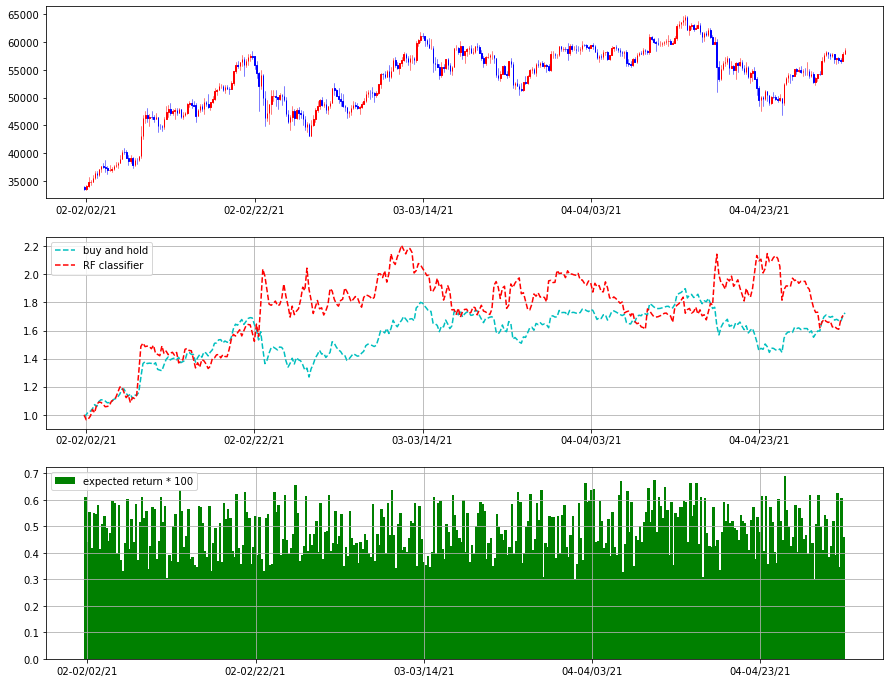

In [16]:
# let's see how the data looks like
ohlc = train_sample[['number', 'open', 'high', 'low', 'close']].copy()

plt.figure(figsize=(15, 12))
p1 = plt.subplot(3, 1, 1)
candlestick_ohlc(p1, ohlc.values, width=0.06, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))

p2 = plt.subplot(3, 1, 2)
p2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))
plt.plot(train_sample.number, train_sample.acc_rtn, 'c--', label="buy and hold")
plt.plot(train_book.number, train_book.acc_rtn, 'r--', label='RF classifier')
plt.legend(loc='best')
plt.grid(True)

p3 = plt.subplot(3, 1, 3)
p3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))
plt.bar(train_book.number, train_book.weight, color='g', width=0.3, label="expected return * 100")
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [17]:
# evaluate
CAGR = test_sample['acc_rtn'].iloc[-1]**(365*4/len(test_sample.index)) - 1.
historical_max = test_sample['acc_rtn'].cummax()
daily_drawdown = test_sample['acc_rtn']/historical_max - 1.
historical_dd = daily_drawdown.cummin()
MDD = historical_dd.min()
VOL = np.std(test_sample['rtn'])*np.sqrt(365*4)
Sharpe = (np.mean(test_sample['rtn'])/np.std(test_sample['rtn']))*np.sqrt(365*4)

print("==== Buy and hold ====")
print(f"CAGR: {round(CAGR*100, 2)}%")
print(f"MDD: {round(MDD*100, 2)}%")
print(f"VOL: {round(VOL*100, 2)}ß%")
print(f"Sharpe: {round(Sharpe*100, 2)}%")

CAGR = test_book['acc_rtn'].iloc[-1]**(365*4/len(test_book.index)) - 1.
historical_max = test_book['acc_rtn'].cummax()
daily_drawdown = test_book['acc_rtn']/historical_max - 1.
historical_dd = daily_drawdown.cummin()
MDD = historical_dd.min()
VOL = np.std(test_book['rtn'])*np.sqrt(365*4)
Sharpe = (np.mean(test_book['rtn'])/np.std(test_book['rtn']))*np.sqrt(365*4)

print("==== RF Classifier ====")
print(f"CAGR: {round(CAGR*100, 2)}%")
print(f"MDD: {round(MDD*100, 2)}%")
print(f"VOL: {round(VOL*100, 2)}%")
print(f"Sharpe: {round(Sharpe*100, 2)}%")

==== Buy and hold ====
CAGR: -99.52%
MDD: -44.61%
VOL: 117.31ß%
Sharpe: -394.42%
==== RF Classifier ====
CAGR: 24.24%
MDD: -44.52%
VOL: 186.66%
Sharpe: 104.25%


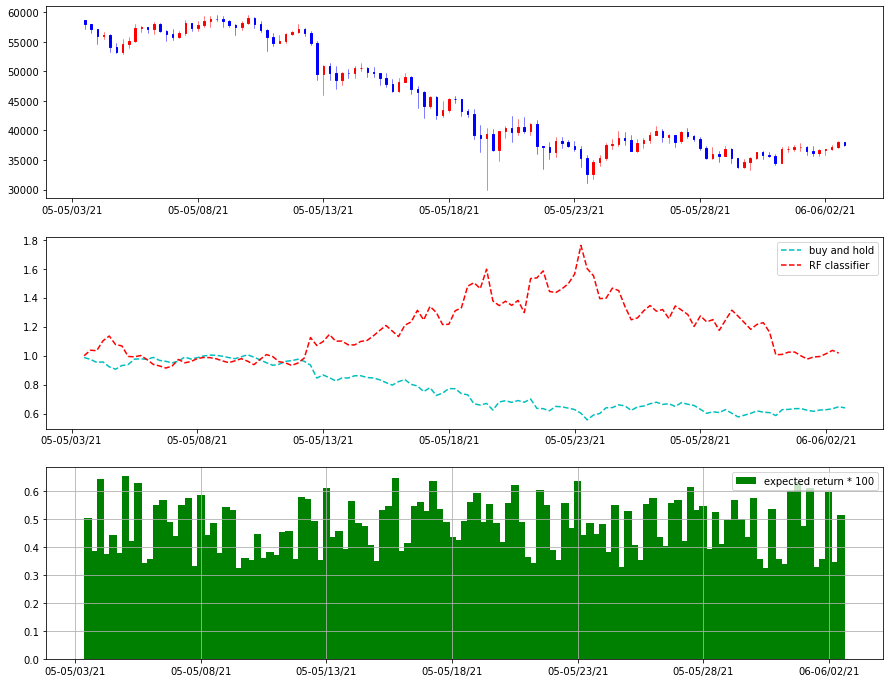

In [18]:
# let's see how the data looks like
ohlc = test_sample[['number', 'open', 'high', 'low', 'close']].copy()

plt.figure(figsize=(15, 12))
p1 = plt.subplot(3, 1, 1)
candlestick_ohlc(p1, ohlc.values, width=0.06, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))

p2 = plt.subplot(3, 1, 2)
p2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))
plt.plot(test_sample.number, test_sample.acc_rtn, 'c--', label="buy and hold")
plt.plot(test_book.number, test_book.acc_rtn, 'r--', label='RF classifier')
plt.legend(loc='best')

p3 = plt.subplot(3, 1, 3)
p3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))
plt.bar(test_book.number, test_book.weight, color='g', width=0.3, label="expected return * 100")
plt.legend(loc='best')
plt.grid(True)
plt.show()